In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from datetime import date
import seaborn as sns
from tqdm import tqdm
from math import sqrt

#sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# PyTorch modules
import torch
import torch.nn as nn
from torch.autograd import Variable

import os
PATH =  './kaggle2'
files = []
for filename in os.listdir(PATH):
    print(os.path.join(PATH, filename))

c:\Users\tinta\.conda\envs\ds\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


./kaggle2\column_description.csv
./kaggle2\sample_submission.csv
./kaggle2\test.csv
./kaggle2\train.csv


In [2]:
# Get data
train = pd.read_csv("./kaggle2/train.csv")
test = pd.read_csv("./kaggle2/test.csv")
print("Taille des données:")
print("train : ", str(train.shape))
print("test:", str(test.shape))

X_train, y_train = train.drop(['FundReturn'], axis=1), train.loc[:, 'FundReturn']
X_test = test

print('X_train:', X_train.shape)
print('X_test:', X_test.shape)

nb_train = X_train.shape[0]
nb_test = X_train.shape[1]

X = pd.concat((X_train, X_test)).reset_index(drop=True)
dates = pd.to_datetime(X['Date'], format = '%Y-%m-%d')
#X = X.drop('Date', axis=1)
print(X.shape)
print(X.columns.sort_values())

Taille des données:
train :  (3779, 24)
test: (808, 23)
X_train: (3779, 23)
X_test: (808, 23)
(4587, 23)
Index(['Australia 10Y Bond', 'BCOM Gold', 'Canada 10Y Bond', 'Copper', 'Date',
       'EM Equities', 'Euro Equities', 'FX AUD/USD', 'FX CAD/USD',
       'FX CHF/USD', 'FX EUR/USD', 'FX GBP/USD', 'FX JPY/USD',
       'Germany 10Y Bond', 'Japan 10Y Bond', 'Japan Equities', 'Oil Brent',
       'UK 10Y Bond', 'UK Equities', 'US 10Y Bond', 'US 2Y Bond',
       'US Equities', 'US Tech Equities'],
      dtype='object')


In [3]:
display(train.head(3))

#plt.plot(dates, fundReturns)
#plt.show()

isNullExists = False
for i in X.isna().sum().sort_values(ascending=False):
    if i != 0:
        isNullExists = True
        break
print('Data has null values:', isNullExists)

# Let check if there are values set to Zero which are NAN hidden values
def show_plots():
    _nrows = X.shape[1] - 1
    f, ax = plt.subplots(nrows=_nrows, ncols=1, figsize=(15, 100))
    for i, column in tqdm(enumerate(X.columns)):
        sns.lineplot(x=dates, y=X.drop('Date', axis=1)[column].fillna(method='ffill'), ax=ax[i], color='dodgerblue')
        ax[i].set_title('Feature: {}'.format(column), fontsize=14)
        ax[i].set_ylabel(ylabel=column, fontsize=14)              
        ax[i].set_xlim([date(2004, 12, 31), date(2023, 2, 23)])
#show_plots()

,Date,US Tech Equities,US Equities,Japan Equities,Euro Equities,UK Equities,EM Equities,US 2Y Bond,US 10Y Bond,Germany 10Y Bond,...,BCOM Gold,Oil Brent,Copper,FX AUD/USD,FX CAD/USD,FX CHF/USD,FX EUR/USD,FX GBP/USD,FX JPY/USD,FundReturn
0,2004-12-31,0.000307,-0.000824,0.000000,0.000000,-0.003117,0.000000,0.000671,0.002378,0.000000,...,0.000000,-0.004903,0.004816,0.008432,0.006450,-0.003272,-0.002713,-0.000640,0.005508,0.001841
1,2005-01-03,-0.007984,-0.006179,0.000000,0.008480,0.000000,0.000000,-0.000447,-0.000558,0.002952,...,-0.019845,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.002598
2,2005-01-04,-0.020426,-0.012642,0.005226,-0.003027,0.007712,-0.011075,-0.001790,-0.004189,-0.000757,...,-0.001163,0.010594,-0.075240,-0.019535,-0.020867,-0.025482,-0.022043,-0.018944,-0.018110,-0.004648


Data has null values: False


C:\Users\tinta\AppData\Local\Temp\ipykernel_19920\2813557008.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = train.corr()


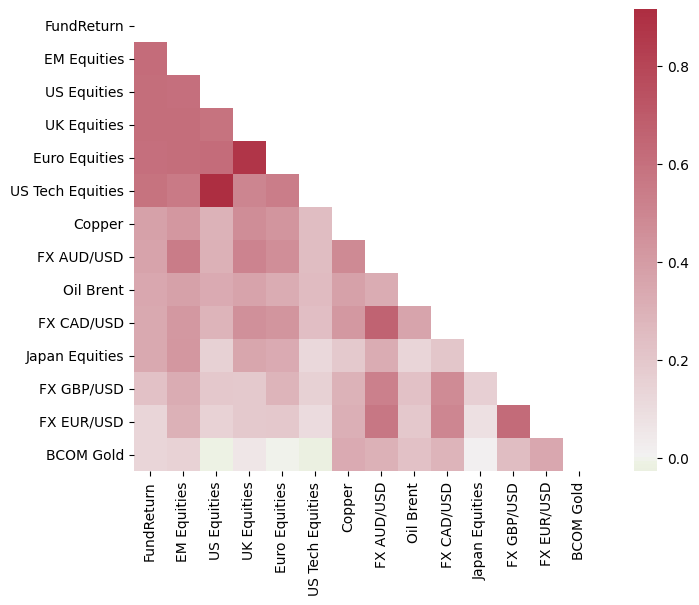

['EM Equities',
 'US Equities',
 'UK Equities',
 'Euro Equities',
 'US Tech Equities',
 'Copper',
 'FX AUD/USD',
 'Oil Brent']

In [4]:
# Find most important features relative to target
corr = train.corr()
corr.sort_values(["FundReturn"], ascending = False, inplace = True)
#print(corr.SalePrice[corr.SalePrice[:] > 0.5])
corr2 = corr[corr.FundReturn[:] > 0.1]
corr2 = corr2.loc[:, list(corr2.index)]

# Create a mask
mask = np.triu(np.ones_like(corr2, dtype=bool))
# Create a custom divergin palette
cmap = sns.diverging_palette(100, 7, s=75, l=40,
                            n=5, center="light", as_cmap=True)
plt.figure(figsize=(10, 6))
sns.heatmap(corr2, mask=mask, center=0, annot=False,
            fmt='.2f', square=True, cmap=cmap)
plt.show()

corrCols = list(corr2.index)[1: 9]
corrCols

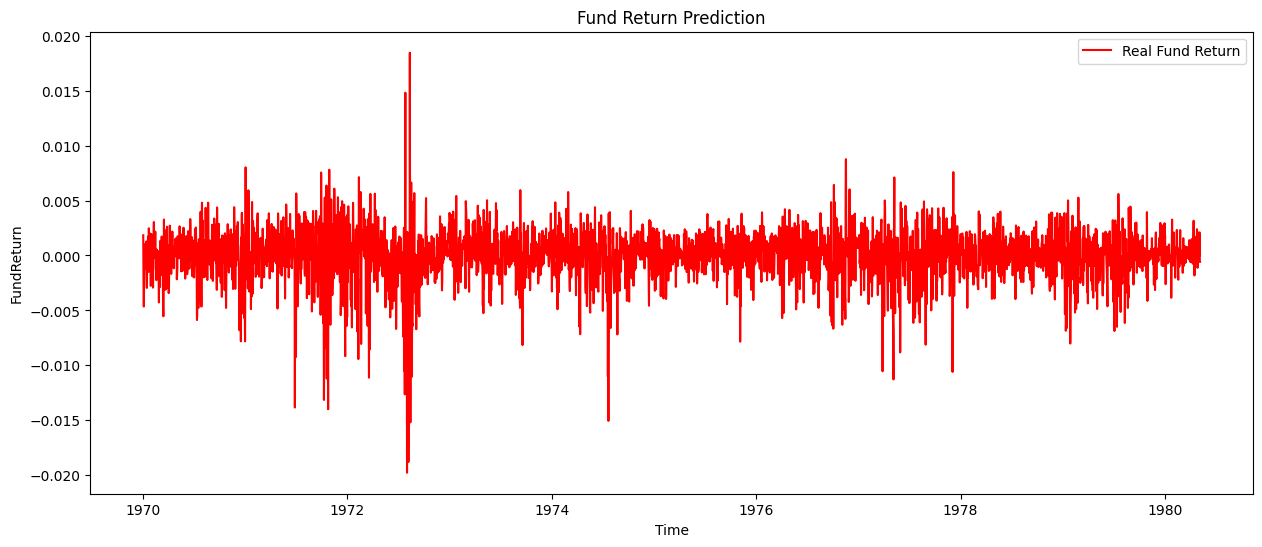

In [5]:
# Visualising the results
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()

#axes.plot(train[len(train)-len(y_test):].index, y_test, color = 'red', label = 'Real Fund Return')
#axes.plot(train[len(train)-len(y_test):].index, y_test_pred, color = 'blue', label = 'Predicted Fund Return')

axes.plot(train[:len(y_train)].index, y_train, color = 'red', label = 'Real Fund Return')

#axes.xticks(np.arange(0,394,50))
plt.title('Fund Return Prediction')
plt.xlabel('Time')
plt.ylabel('FundReturn')
plt.legend()
plt.savefig('pred.png')
plt.show()

In [18]:
X, y = train.drop(columns=[x for x in train.columns if x not in corrCols]), train.FundReturn.values
X.shape, y.shape

((3779, 8), (3779,))

### Scaling or not scaling, that's the question

In [19]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm = MinMaxScaler()
ss = StandardScaler()

# X_trans = ss.fit_transform(X)
# y_trans = mm.fit_transform(y.reshape(-1, 1))
X_trans = X # No scaling
y_trans = y.reshape(-1, 1) # No scaling

### Linear Models

In [20]:
import optuna
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn import model_selection
from sklearn.metrics import mean_squared_error

#Grabbing a sklearn Classification dataset:
X, y = X_train.drop('Date', axis=1), y_train

# class 1 
def objective(trial , X = X , y = y, isTestParams=True):
    train_x , test_x , train_y , test_y = train_test_split(
        X, y, test_size = 0.2)
    # regressor_name = trial.suggest_categorical('regressor', ['LinearRegression', 'Lasso', 'Ridge', 'ElasticNet'])
    regressor_name = trial.suggest_categorical('regressor', ['Ridge'])
    if regressor_name == 'LinearRegression':
        regressor_obj = LinearRegression()
    if regressor_name == 'Lasso':
        params_lasso = {'alpha' : trial.suggest_float('alpha' , 0 , 1)}
        if isTestParams:
            regressor_obj = Lasso(**params_lasso)
        else:
            regressor_obj = Lasso()
    if regressor_name == 'Ridge':
        params_ridge = {'alpha' : trial.suggest_float('alpha' , 0 , 1)}
        if isTestParams:
            regressor_obj = Ridge(**params_ridge)
        else:
            regressor_obj = Ridge()
    if regressor_name == 'ElasticNet':
        params_el = {
        'alpha' : trial.suggest_float('alpha' , 0 , 1),
        'l1_ratio' : trial.suggest_float('l1_ratio', 0, 1)}
        if isTestParams:
            regressor_obj = ElasticNet(**params_el)
        else:
            regressor_obj = ElasticNet()

    regressor_obj.fit(train_x , train_y)
    y_pred = regressor_obj.predict(test_x)
    ll = mean_squared_error(test_y , y_pred)
    return ll
optuna.logging.set_verbosity(optuna.logging.WARNING) # i do not want to see trail information
study = optuna.create_study(direction = 'minimize' , study_name = 'lr'
                            , pruner = optuna.pruners.HyperbandPruner() 
                           )
study.optimize(objective, n_trials = 1000)
print('numbers of the finished trials:' , len(study.trials))
print('the best params:' , study.best_trial.params)
print('the best value:' , study.best_value)

numbers of the finished trials: 1000
the best params: {'regressor': 'Ridge', 'alpha': 0.06126065798922016}
the best value: 2.010112755289353e-06


### LSTM

In [21]:
def load_X_sequence(input_sequences, n_steps_in, n_steps_out):
    X = list()# instantiate X and y
    for i in range(len(input_sequences)):
        # find the end of the input, output sequence
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out - 1
        # check if we are beyond the dataset
        if out_end_ix > len(input_sequences): break
        # gather input and output of the pattern
        seq_x = input_sequences[i:end_ix]
        X.append(seq_x)
    return np.array(X)

In [22]:
def split_sequences(input_sequences, output_sequence, n_steps_in, n_steps_out):
    X, y = list(), list() # instantiate X and y
    for i in range(len(input_sequences)):
        # find the end of the input, output sequence
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out - 1
        # check if we are beyond the dataset
        if out_end_ix > len(input_sequences): break
        # gather input and output of the pattern
        seq_x, seq_y = input_sequences[i:end_ix], output_sequence[end_ix-1:out_end_ix, -1]
        X.append(seq_x), y.append(seq_y)
    return np.array(X), np.array(y)

In [23]:
X_ss, y_mm = split_sequences(X_trans, y_trans, 30, 1)
print(X_ss.shape, y_mm.shape)
# X_train, y_train = split_sequences(X_trans, y_trans, 30, 1)

(3750, 30, 8) (3750, 1)


In [24]:
total_samples = len(X)
train_test_cutoff = round(0.95 * total_samples)

X_train = X_ss[:train_test_cutoff]
X_test = X_ss[train_test_cutoff:]

y_train = y_mm[:train_test_cutoff]
y_test = y_mm[train_test_cutoff:] 

In [25]:
print("Training Shape:", X_train.shape, y_train.shape)
print("Testing Shape:", X_test.shape, y_test.shape) 

Training Shape: (3590, 30, 8) (3590, 1)
Testing Shape: (160, 30, 8) (160, 1)


In [26]:
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

In [27]:
X_train_tensors_final = torch.reshape(X_train_tensors,   
                                      (X_train_tensors.shape[0], 30, 
                                       X_train_tensors.shape[2]))
X_test_tensors_final = torch.reshape(X_test_tensors,  
                                     (X_test_tensors.shape[0], 30, 
                                      X_test_tensors.shape[2]))

In [28]:
print("Training Shape:", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape:", X_test_tensors_final.shape, y_test_tensors.shape) 

Training Shape: torch.Size([3590, 30, 8]) torch.Size([3590, 1])
Testing Shape: torch.Size([160, 30, 8]) torch.Size([160, 1])


In [29]:
class LSTM(nn.Module):
    
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super().__init__()
        self.num_classes = num_classes # output size
        self.num_layers = num_layers # number of recurrent layers in the lstm
        self.input_size = input_size # input size
        self.hidden_size = hidden_size # neurons in each lstm layer
        # LSTM model
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, dropout=0.2) # lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) # fully connected 
        self.fc_2 = nn.Linear(128, num_classes) # fully connected last layer
        self.relu = nn.ReLU()
        
    def forward(self,x):
        # hidden state
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        # cell state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        # propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # (input, hidden, and internal state)
        hn = hn.view(-1, self.hidden_size) # reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) # first dense
        out = self.relu(out) # relu
        out = self.fc_2(out) # final output
        return out

In [30]:
def training_loop(n_epochs, lstm, optimiser, loss_fn, X_train, y_train,
                  X_test, y_test):
    for epoch in range(n_epochs):
        lstm.train()
        outputs = lstm.forward(X_train) # forward pass
        optimiser.zero_grad() # calculate the gradient, manually setting to 0
        # obtain the loss function
        loss = loss_fn(outputs, y_train)
        loss.backward() # calculates the loss of the loss function
        optimiser.step() # improve from loss, i.e backprop
        # test loss
        lstm.eval()
        test_preds = lstm(X_test)
        test_loss = loss_fn(test_preds, y_test)
        if epoch % 100 == 0:
            print("Epoch: %d, train loss: %1.5f, test loss: %1.5f" % (epoch, 
                                                                      loss.item(), 
                                                                      test_loss.item()))

In [31]:
import warnings
warnings.filterwarnings('ignore')

n_epochs = 500 # 1000 epochs
learning_rate = 0.001 # 0.001 lr

input_size = len(corrCols) # number of features
hidden_size = 4 # number of features in hidden state
num_layers = 1 # number of stacked lstm layers

num_classes = 1 # number of output classes 

lstm = LSTM(num_classes, 
              input_size, 
              hidden_size, 
              num_layers)

loss_fn = torch.nn.MSELoss()    # mean-squared error for regression
optimiser = torch.optim.Adam(lstm.parameters(), lr=learning_rate) 

In [ ]:
training_loop(n_epochs=n_epochs,
              lstm=lstm,
              optimiser=optimiser,
              loss_fn=loss_fn,
              X_train=X_train_tensors_final,
              y_train=y_train_tensors,
              X_test=X_test_tensors_final,
              y_test=y_test_tensors)

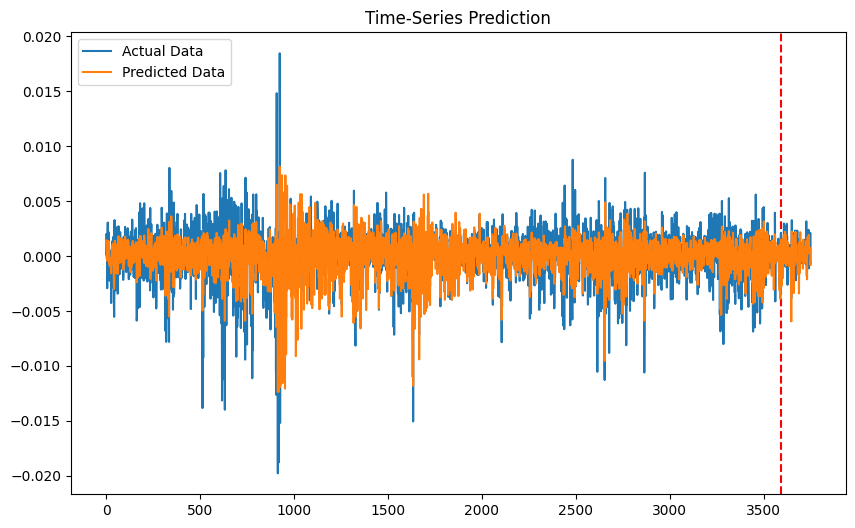

In [35]:
# df_X_ss = ss.transform(train.drop(columns=[x for x in train.columns if x not in corrCols])) # old transformers
# df_y_mm = mm.transform(train.FundReturn.values.reshape(-1, 1)) # old transformers
df_X_ss = train.drop(columns=[x for x in train.columns if x not in corrCols])
df_y_mm = train.FundReturn.values.reshape(-1, 1)
# split the sequence
df_X_ss, df_y_mm = split_sequences(df_X_ss, df_y_mm, 30, 1)
# converting to tensors
df_X_ss = Variable(torch.Tensor(df_X_ss))
df_y_mm = Variable(torch.Tensor(df_y_mm))
# reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 30, df_X_ss.shape[2]))

train_predict = lstm(df_X_ss) # forward pass
data_predict = train_predict.data.numpy() # numpy conversion
dataY_plot = df_y_mm.data.numpy()

# data_predict = mm.inverse_transform(data_predict) # reverse transformation
# dataY_plot = mm.inverse_transform(dataY_plot)
true, preds = [], []
for i in range(len(dataY_plot)):
    true.append(dataY_plot[i][0])
for i in range(len(data_predict)):
    preds.append(data_predict[i][0])
plt.figure(figsize=(10,6)) #plotting
plt.axvline(x=train_test_cutoff, c='r', linestyle='--') # size of the training set

plt.plot(true, label='Actual Data') # actual plot
plt.plot(preds, label='Predicted Data') # predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.savefig("fundReturn_lstm_multivariate.png", dpi=300)
plt.show() 

### Submission

In [36]:
temp = pd.concat([train.tail(30).iloc[:-1].drop('FundReturn', axis=1), test], axis=0)
temp.shape

(837, 23)

808


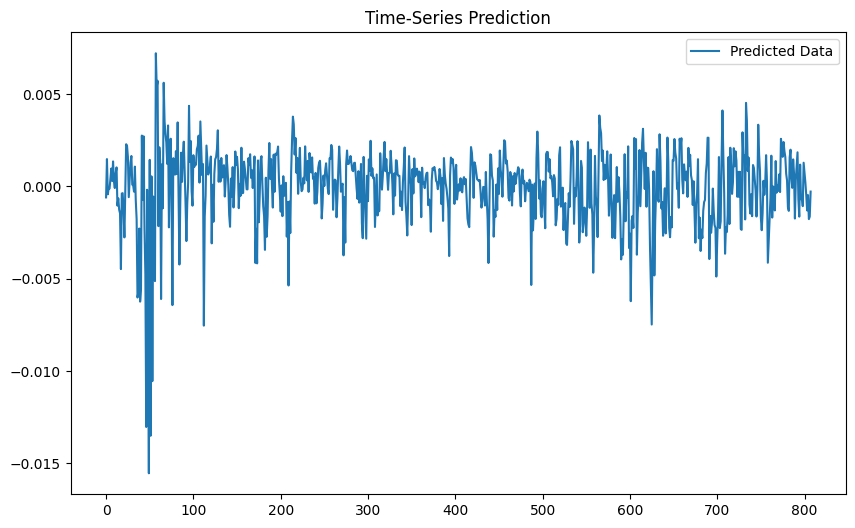

In [43]:
# df_X_ss = ss.transform(temp.drop(columns=[x for x in train.drop('FundReturn', axis=1).columns if x not in corrCols])) # old transformers
df_X_ss = temp.drop(columns=[x for x in train.drop('FundReturn', axis=1).columns if x not in corrCols])
# split the sequence
df_X_ss = load_X_sequence(df_X_ss, 30, 1)
print(len(df_X_ss))
# converting to tensors
df_X_ss = Variable(torch.Tensor(df_X_ss))
# reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 30, df_X_ss.shape[2]))

test_predict = lstm(df_X_ss) # forward pass
data_predict = test_predict.data.numpy() # numpy conversion

# data_predict = mm.inverse_transform(data_predict) # reverse transformation
preds = []

for i in range(len(data_predict)):
    preds.append(data_predict[i][0])
plt.figure(figsize=(10,6)) #plotting
# plt.axvline(x=train_test_cutoff, c='r', linestyle='--') # size of the training set
plt.plot(preds, label='Predicted Data') # predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.savefig("fundReturn_lstm_multivariate.png", dpi=300)
plt.show() 

In [44]:
pd.DataFrame({'FundReturn':preds})

,FundReturn
0,-0.000602
1,0.001473
2,-0.000433
3,-0.000102
4,-0.000122
...,...
803,-0.001309
804,-0.000477
805,-0.001777
806,-0.001641


In [45]:
res = pd.concat([test['Date'], pd.DataFrame({'FundReturn':preds})], axis=1)
res.set_index('Date', inplace=True)
res.to_csv('fundReturn_lstm_multivariate.csv')
res.head()

,FundReturn
Date,
2019-12-31,-0.000602
2020-01-02,0.001473
2020-01-03,-0.000433
2020-01-06,-0.000102
2020-01-07,-0.000122
